In [1]:
import numpy as np
import scipy.stats as stats
import scipy.signal as signal
from scipy.ndimage import median_filter
import statsmodels.tsa.stattools as stattools
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

MIN_WINDOW_SEC = 2  

def extract_features(xyz, sample_rate=100):
    '''Extract commonly used HAR time-series features. xyz is a window of shape (N,3)'''
    
    if np.isnan(xyz).any():
        return {}
    
    if len(xyz) <= MIN_WINDOW_SEC * sample_rate:
        return {}
    
    feats = {}
    
    v = np.linalg.norm(xyz, axis=1)
    v = median_filter(v, size=5, mode='nearest')
    v = v - 1  # detrend: "remove gravity"
    v = np.clip(v, -2, 2)  # clip abnormaly high values
    
    # Moments features
    feats.update(moments_features(v, sample_rate))
    
    # Quantile features
    feats.update(quantile_features(v, sample_rate))
    
    # Autocorrelation features
    feats.update(autocorr_features(v, sample_rate))
    
    # Spectral features
    feats.update(spectral_features(v, sample_rate))
    
    # FFT features
    feats.update(fft_features(v, sample_rate))
    
    # Peak features
    feats.update(peaks_features(v, sample_rate))
    
    return feats


def moments_features(v, sample_rate=None):
    """Moments"""
    avg = np.mean(v)
    std = np.std(v)
    if std > .01:
        skew = np.nan_to_num(stats.skew(v))
        kurt = np.nan_to_num(stats.kurtosis(v))
    else:
        skew = kurt = 0
    feats = {
        'avg': avg,
        'std': std,
        'skew': skew,
        'kurt': kurt,
    }
    return feats


def quantile_features(v, sample_rate=None):
    """Quantiles (min, 25th, med, 75th, max)"""
    feats = {}
    feats['min'], feats['q25'], feats['med'], feats['q75'], feats['max'] = np.quantile(v, (0, .25, .5, .75, 1))
    return feats


def autocorr_features(v, sample_rate):
    """Autocorrelation features"""
    
    with np.errstate(divide='ignore', invalid='ignore'):  # ignore invalid div warnings
        u = np.nan_to_num(stattools.acf(v, nlags=2 * sample_rate))
    
    peaks, _ = signal.find_peaks(u, prominence=.1)
    if len(peaks) > 0:
        acf_1st_max_loc = peaks[0]
        acf_1st_max = u[acf_1st_max_loc]
        acf_1st_max_loc /= sample_rate  # in secs
    else:
        acf_1st_max = acf_1st_max_loc = 0.0
    
    valleys, _ = signal.find_peaks(-u, prominence=.1)
    if len(valleys) > 0:
        acf_1st_min_loc = valleys[0]
        acf_1st_min = u[acf_1st_min_loc]
        acf_1st_min_loc /= sample_rate  # in secs
    else:
        acf_1st_min = acf_1st_min_loc = 0.0
    
    acf_zeros = np.sum(np.diff(np.signbit(u)))
    
    feats = {
        'acf_1st_max': acf_1st_max,
        'acf_1st_max_loc': acf_1st_max_loc,
        'acf_1st_min': acf_1st_min,
        'acf_1st_min_loc': acf_1st_min_loc,
        'acf_zeros': acf_zeros,
    }
    
    return feats


def spectral_features(v, sample_rate):
    """Spectral entropy, average power, dominant frequencies"""
    
    feats = {}
    
    freqs, powers = signal.periodogram(v, fs=sample_rate, detrend='constant', scaling='density')
    powers /= (len(v) / sample_rate)    # unit/sec
    
    feats['pentropy'] = stats.entropy(powers[powers > 0])
    feats['power'] = np.sum(powers)
    
    peaks, _ = signal.find_peaks(powers)
    peak_powers = powers[peaks]
    peak_freqs = freqs[peaks]
    peak_ranks = np.argsort(peak_powers)[::-1]
    
    TOPN = 3
    feats.update({f"f{i + 1}": 0 for i in range(TOPN)})
    feats.update({f"p{i + 1}": 0 for i in range(TOPN)})
    for i, j in enumerate(peak_ranks[:TOPN]):
        feats[f"f{i + 1}"] = peak_freqs[j]
        feats[f"p{i + 1}"] = peak_powers[j]
    
    return feats


def fft_features(v, sample_rate, nfreqs=5):
    """Power of frequencies 0Hz, 1Hz, 2Hz, ... using Welch's method"""
    
    _, powers = signal.welch(
        v, fs=sample_rate,
        nperseg=sample_rate,
        noverlap=sample_rate // 2,
        detrend='constant',
        scaling='density',
        average='median'
    )
    
    feats = {f"fft{i}": powers[i] for i in range(nfreqs + 1)}
    
    return feats


def peaks_features(v, sample_rate):
    """Features of the signal peaks"""
    
    feats = {}
    u = butterfilt(v, 5, fs=sample_rate)  # lowpass 5Hz
    peaks, peak_props = signal.find_peaks(u, distance=0.2 * sample_rate, prominence=0.25)
    feats['npeaks'] = len(peaks) / (len(v) / sample_rate)  # peaks/sec
    if len(peak_props['prominences']) > 0:
        feats['peaks_avg_promin'] = np.mean(peak_props['prominences'])
        feats['peaks_min_promin'] = np.min(peak_props['prominences'])
        feats['peaks_max_promin'] = np.max(peak_props['prominences'])
    else:
        feats['peaks_avg_promin'] = feats['peaks_min_promin'] = feats['peaks_max_promin'] = 0
    
    return feats


def butterfilt(x, cutoffs, fs, order=4, axis=0):
    """Butterworth filter"""
    nyq = 0.5 * fs
    if isinstance(cutoffs, tuple):
        hicut, lowcut = cutoffs
        if hicut > 0:
            btype = 'bandpass'
            Wn = (hicut / nyq, lowcut / nyq)
        else:
            btype = 'low'
            Wn = lowcut / nyq
    else:
        btype = 'low'
        Wn = cutoffs / nyq
    sos = signal.butter(order, Wn, btype=btype, analog=False, output='sos')
    y = signal.sosfiltfilt(sos, x, axis=axis)
    return y


def get_feature_names():
    """Get the list of feature names in consistent order"""
    # Create a dummy window to extract feature names
    dummy_window = np.random.randn(500, 3) * 0.1
    feats = extract_features(dummy_window, 100)
    return list(feats.keys())


def extract_features_batch(X, sample_rate=100, batch_size=1000):
    """
    Extract features from all windows in X
    
    Parameters:
    -----------
    X : numpy array of shape (n_samples, n_timesteps, 3)
        The input accelerometer data
    sample_rate : int
        Sampling rate in Hz (default 100)
    batch_size : int
        Number of windows to process at once for progress updates
    
    Returns:
    --------
    X_features : numpy array of shape (n_samples, 32)
        Extracted features for all windows
    feature_names : list
        Names of the features in order
    """
    
    n_samples = X.shape[0]
    
    # Get feature names from a dummy extraction
    feature_names = get_feature_names()
    n_features = len(feature_names)
    
    print(f"Extracting {n_features} features from {n_samples} windows...")
    print(f"Features: {feature_names}")
    
    # Initialize feature matrix
    X_features = np.zeros((n_samples, n_features), dtype=np.float32)
    
    # Track failed extractions
    failed_indices = []
    
    # Process in batches for progress tracking
    for batch_start in tqdm(range(0, n_samples, batch_size), desc="Processing batches"):
        batch_end = min(batch_start + batch_size, n_samples)
        
        for i in range(batch_start, batch_end):
            try:
                # Extract features for this window
                features = extract_features(X[i], sample_rate)
                
                if features:  # If extraction was successful
                    # Fill in the feature values in consistent order
                    for j, feat_name in enumerate(feature_names):
                        X_features[i, j] = features.get(feat_name, 0.0)
                else:
                    # Mark as failed extraction
                    failed_indices.append(i)
                    
            except Exception as e:
                print(f"\nError processing window {i}: {e}")
                failed_indices.append(i)
    
    if failed_indices:
        print(f"\nWarning: {len(failed_indices)} windows failed feature extraction")
        print(f"Failed indices: {failed_indices[:10]}..." if len(failed_indices) > 10 else f"Failed indices: {failed_indices}")
    
    print(f"\nFeature extraction complete!")
    print(f"Output shape: {X_features.shape}")
    print(f"Features extracted: {feature_names}")
    
    # Basic statistics
    print(f"\nFeature statistics:")
    print(f"  Min values: {np.min(X_features, axis=0)[:5]}...")
    print(f"  Max values: {np.max(X_features, axis=0)[:5]}...")
    print(f"  Mean values: {np.mean(X_features, axis=0)[:5]}...")
    print(f"  NaN count: {np.isnan(X_features).sum()}")
    print(f"  Inf count: {np.isinf(X_features).sum()}")
    
    return X_features, feature_names


def load_prepared_data(data_dir='preprocessed', schema='WillettsSpecific2018'):
    """Load preprocessed data"""
    print(f"Loading prepared data from: {data_dir}")
    
    X = np.load(os.path.join(data_dir, 'X.npy'))
    Y = np.load(os.path.join(data_dir, f'Y_{schema}.npy'), allow_pickle=True)
    T = np.load(os.path.join(data_dir, 'T.npy'), allow_pickle=True)
    P = np.load(os.path.join(data_dir, 'P.npy'), allow_pickle=True)
    
    print(f"\nLoaded data:")
    print(f"  X shape: {X.shape}")
    print(f"  Y shape: {Y.shape}")
    print(f"  Number of participants: {len(np.unique(P))}")
    
    return X, Y, T, P


def save_features(X_features, feature_names, save_dir='preprocessed'):
    """Save extracted features and feature names"""
    
    # Create directory
    os.makedirs(save_dir, exist_ok=True)
    
    # Save features
    features_path = os.path.join(save_dir, 'X_features.npy')
    np.save(features_path, X_features)
    print(f"\nSaved features to: {features_path}")
    
    # Save feature names
    names_path = os.path.join(save_dir, 'feature_names.npy')
    np.save(names_path, np.array(feature_names))
    print(f"Saved feature names to: {names_path}")
    
    return features_path, names_path


# Main execution
if __name__ == "__main__":
    
    # Load data
    X, Y, T, P = load_prepared_data(schema='WillettsSpecific2018')
    
    # Extract features from all windows
    # Assuming 100Hz sample rate (1000 timesteps = 10 seconds at 100Hz)
    X_features, feature_names = extract_features_batch(X, sample_rate=100, batch_size=1000)
    
    # Save the features
    save_features(X_features, feature_names)
    
    print("\n" + "="*50)
    print("Feature extraction completed successfully!")
    print(f"Original data shape: {X.shape}")
    print(f"Feature matrix shape: {X_features.shape}")
    print("="*50)

Loading prepared data from: preprocessed

Loaded data:
  X shape: (1398022, 1000, 3)
  Y shape: (1398022,)
  Number of participants: 151
Extracting 32 features from 1398022 windows...
Features: ['avg', 'std', 'skew', 'kurt', 'min', 'q25', 'med', 'q75', 'max', 'acf_1st_max', 'acf_1st_max_loc', 'acf_1st_min', 'acf_1st_min_loc', 'acf_zeros', 'pentropy', 'power', 'f1', 'f2', 'f3', 'p1', 'p2', 'p3', 'fft0', 'fft1', 'fft2', 'fft3', 'fft4', 'fft5', 'npeaks', 'peaks_avg_promin', 'peaks_min_promin', 'peaks_max_promin']


Processing batches: 100%|██████████| 1399/1399 [29:34<00:00,  1.27s/it]



Feature extraction complete!
Output shape: (1398022, 32)
Features extracted: ['avg', 'std', 'skew', 'kurt', 'min', 'q25', 'med', 'q75', 'max', 'acf_1st_max', 'acf_1st_max_loc', 'acf_1st_min', 'acf_1st_min_loc', 'acf_zeros', 'pentropy', 'power', 'f1', 'f2', 'f3', 'p1', 'p2', 'p3', 'fft0', 'fft1', 'fft2', 'fft3', 'fft4', 'fft5', 'npeaks', 'peaks_avg_promin', 'peaks_min_promin', 'peaks_max_promin']

Feature statistics:
  Min values: [ -0.1642207    0.         -16.381773    -1.9261225   -0.98326266]...
  Max values: [1.7581493e+00 1.0460494e+00 2.8646334e+01 8.7671014e+02 6.9947183e-01]...
  Mean values: [ 0.01215498  0.06573144  0.53021324  5.2717385  -0.1811054 ]...
  NaN count: 0
  Inf count: 0

Saved features to: preprocessed/X_features.npy
Saved feature names to: preprocessed/feature_names.npy

Feature extraction completed successfully!
Original data shape: (1398022, 1000, 3)
Feature matrix shape: (1398022, 32)


Loading data...
Features shape: (1398022, 32)
Labels shape: (1398022,)
Label type: <U32
Number of unique classes: 11
Classes: ['bicycling' 'household-chores' 'manual-work' 'mixed-activity' 'nan'
 'sitting' 'sleep' 'sports' 'standing' 'vehicle' 'walking']

Handling labels...
Removed 475823 samples with 'nan' labels
Remaining samples: 922199

Label mapping:
  0: Light
  1: Moderate-Vigorous
  2: Sedentary
  3: Sleep

Using participant-based split...
Training set: (618129, 32)
Test set: (304070, 32)

Training XGBoost model...
Training complete!

Making predictions...
Applying HMM smoothing...


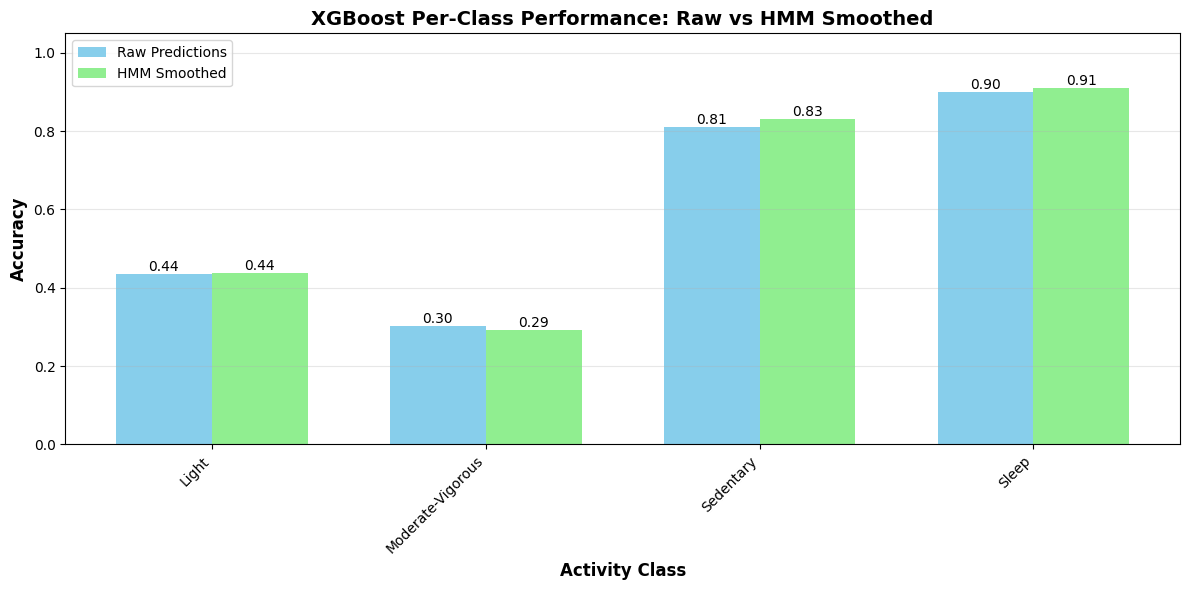

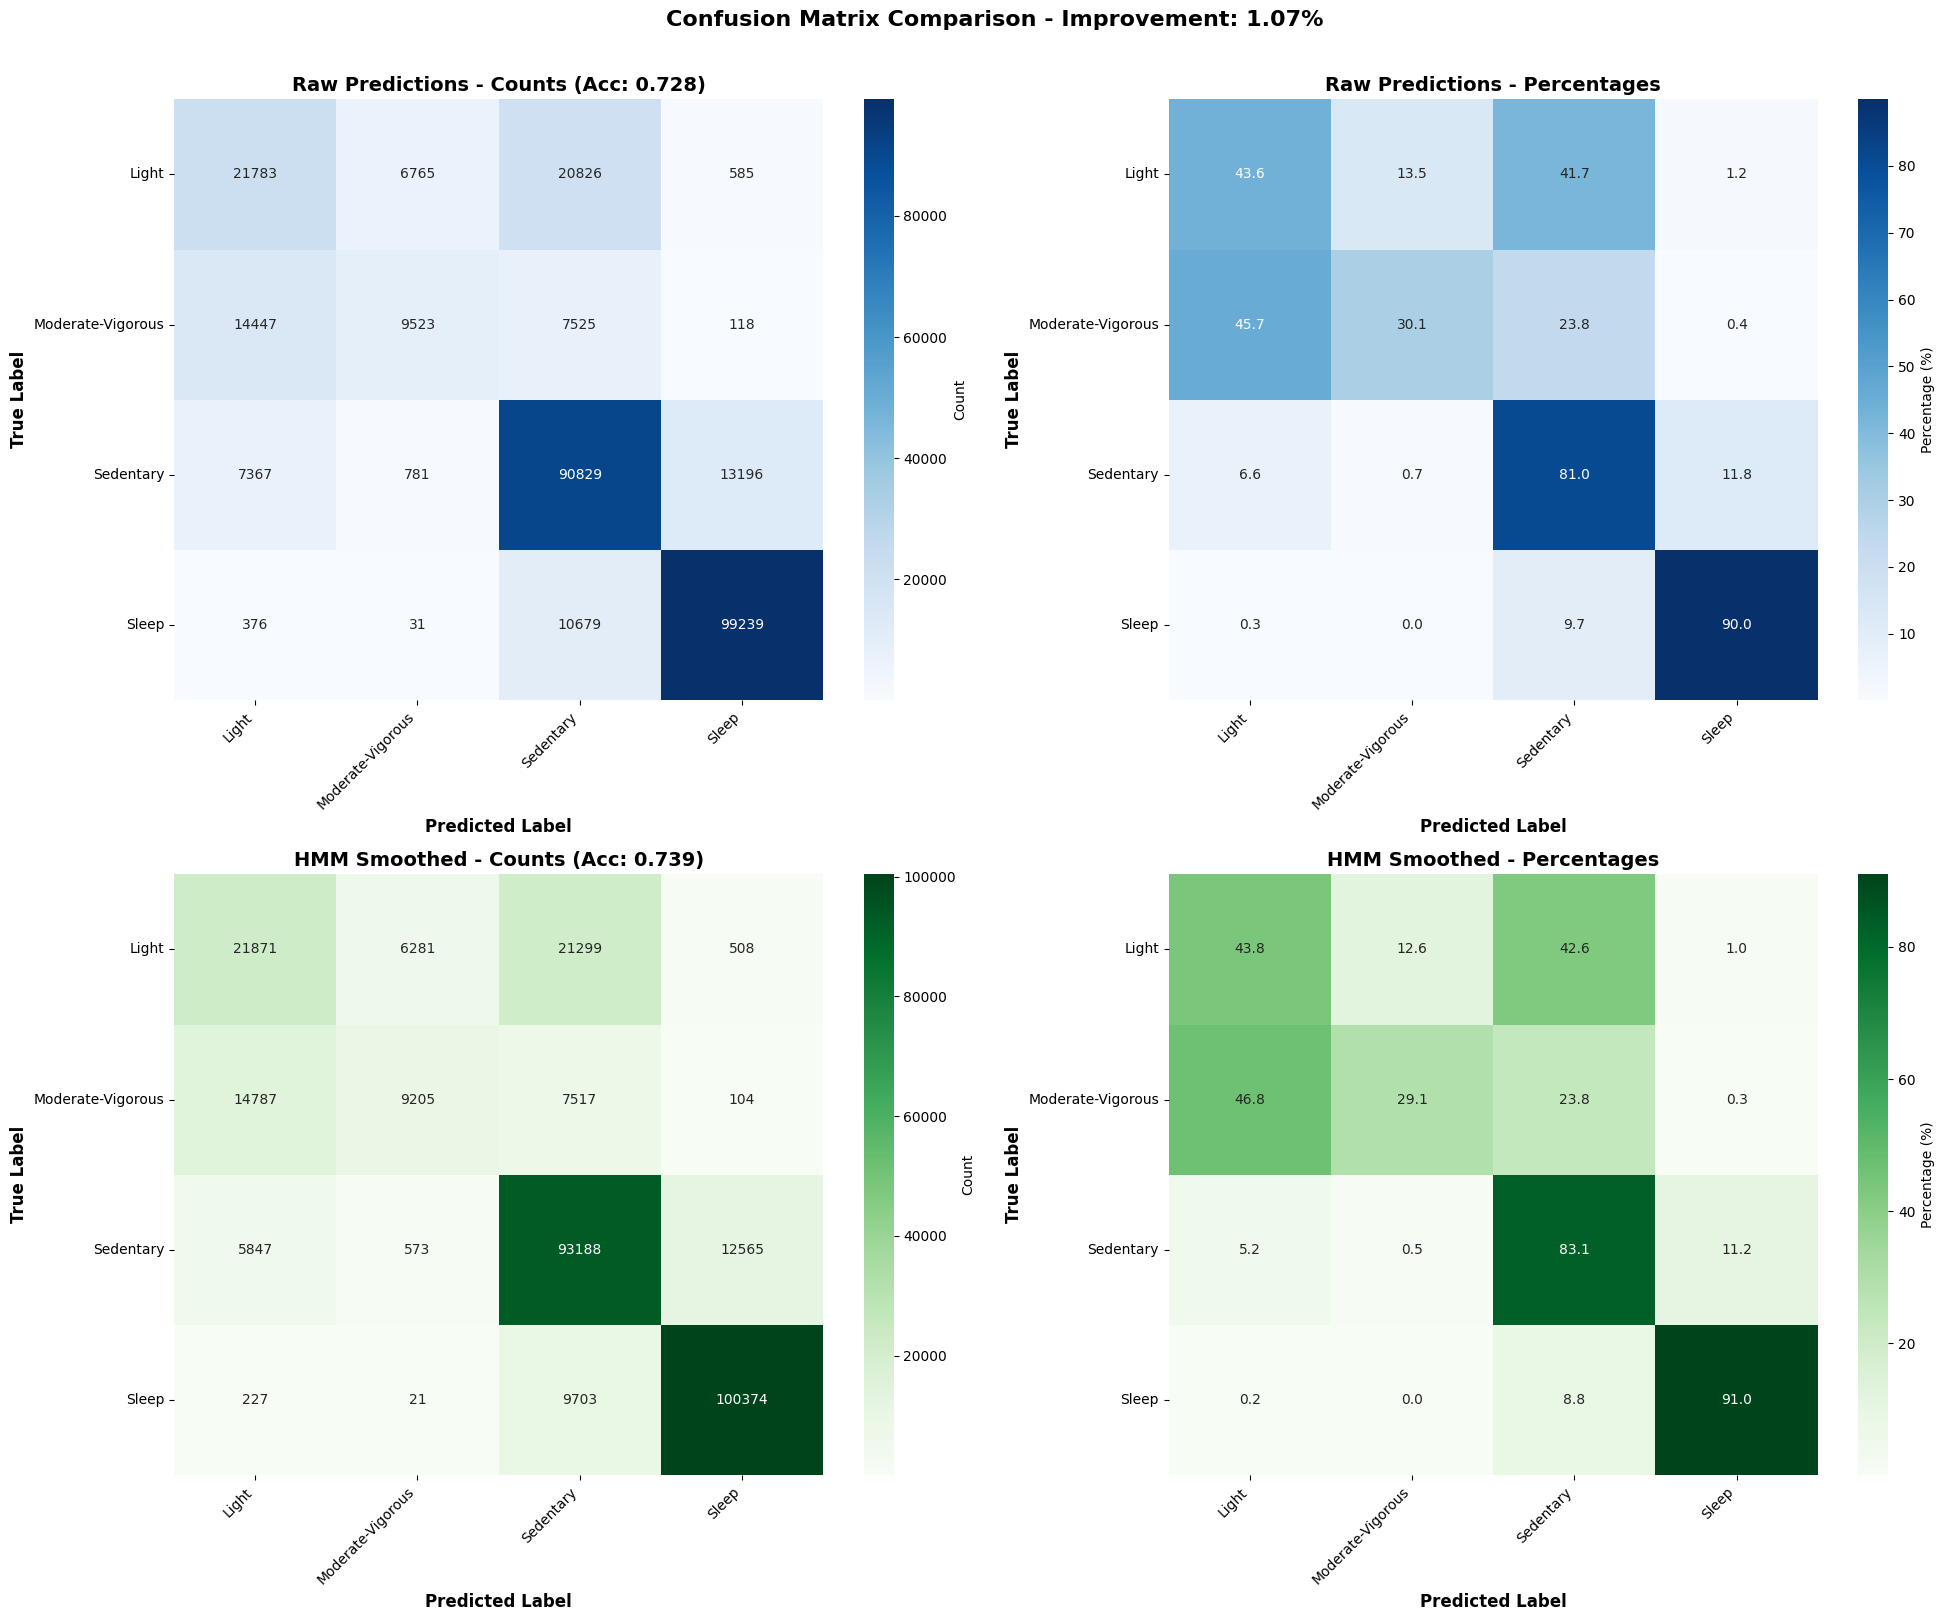


Per-Class Accuracy Changes:
  Light               : 0.436 → 0.438 (+0.2%)
  Moderate-Vigorous   : 0.301 → 0.291 (-1.0%)
  Sedentary           : 0.810 → 0.831 (+2.1%)
  Sleep               : 0.900 → 0.910 (+1.0%)

Calculating metrics...

MODEL PERFORMANCE COMPARISON
Raw Predictions:
  Accuracy: 0.7280
  Macro F1: 0.6234

Smoothed Predictions (HMM):
  Accuracy: 0.7388
  Macro F1: 0.6297

Improvement:
  Accuracy: +1.07%
  Macro F1: +0.63%

Detailed Metrics (Smoothed):
Macro Precision: 0.6689
Macro Recall: 0.6174
Weighted F1: 0.7249
Weighted Precision: 0.7253
Weighted Recall: 0.7388

Per-class Performance (Smoothed):
  Light               : 0.438
  Moderate-Vigorous   : 0.291
  Sedentary           : 0.831
  Sleep               : 0.910

Predictions saved to 'predictions_with_hmm.csv'

Training Completed with HMM Smoothing
Final test accuracy: 73.88%


In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

def load_data_and_features(data_dir='preprocessed', schema='WillettsSpecific2018'):
    """Load features and labels"""
    print("Loading data...")
    
    # Load features
    X_features = np.load(os.path.join(data_dir, 'X_features.npy'))
    
    # Load labels
    Y = np.load(os.path.join(data_dir, f'Y_{schema}.npy'), allow_pickle=True)
    
    # Load participant IDs and timestamps
    P = np.load(os.path.join(data_dir, 'P.npy'), allow_pickle=True)
    T = np.load(os.path.join(data_dir, 'T.npy'), allow_pickle=True)  # ADDED: Load timestamps
    
    print(f"Features shape: {X_features.shape}")
    print(f"Labels shape: {Y.shape}")
    print(f"Label type: {Y.dtype}")
    print(f"Number of unique classes: {len(np.unique(Y))}")
    print(f"Classes: {np.unique(Y)}")
    
    return X_features, Y, P, T  # CHANGED: Return T as well

def apply_hmm_smoothing(y_pred, y_pred_proba, P_test, T_test, min_confidence=0.6):
    """
    Apply HMM-like smoothing to predictions based on temporal continuity
    
    Simple approach: If surrounded by same class and low confidence, switch
    """
    y_smoothed = y_pred.copy()
    
    # Process each participant separately
    for participant in np.unique(P_test):
        # Get this participant's data
        mask = P_test == participant
        part_preds = y_pred[mask].copy()
        part_proba = y_pred_proba[mask]
        part_times = T_test[mask]
        
        # Sort by time
        time_order = np.argsort(part_times)
        part_preds = part_preds[time_order]
        part_proba = part_proba[time_order]
        part_times = part_times[time_order]
        
        # Get max confidence for each prediction
        max_confidence = np.max(part_proba, axis=1)
        
        # Simple smoothing: fix low-confidence predictions surrounded by same class
        for i in range(1, len(part_preds) - 1):
            # Check if low confidence
            if max_confidence[i] < min_confidence:
                # Check if surrounded by same class
                if part_preds[i-1] == part_preds[i+1]:
                    # Check temporal proximity (within 30 seconds)
                    if (pd.to_datetime(part_times[i+1]) - pd.to_datetime(part_times[i-1])).total_seconds() <= 30:
                        part_preds[i] = part_preds[i-1]
        
        # Put back in original order
        y_smoothed[mask] = part_preds[np.argsort(time_order)]
    
    return y_smoothed

def visualize_hmm_comparison(y_test, y_pred, y_pred_smoothed, label_encoder):
    """
    Create confusion matrix visualization comparing raw vs HMM smoothed predictions
    
    Parameters:
    -----------
    y_test : array
        True labels (encoded)
    y_pred : array
        Raw predictions from model
    y_pred_smoothed : array
        Smoothed predictions after HMM
    label_encoder : LabelEncoder
        To get class names
    """
    
    # Calculate confusion matrices
    cm_raw = confusion_matrix(y_test, y_pred)
    cm_smoothed = confusion_matrix(y_test, y_pred_smoothed)
    
    # Calculate percentages
    cm_raw_percentage = cm_raw.astype('float') / cm_raw.sum(axis=1)[:, np.newaxis] * 100
    cm_smoothed_percentage = cm_smoothed.astype('float') / cm_smoothed.sum(axis=1)[:, np.newaxis] * 100
    
    class_names = label_encoder.classes_
    
    # Calculate accuracies
    acc_raw = accuracy_score(y_test, y_pred)
    acc_smoothed = accuracy_score(y_test, y_pred_smoothed)
    
    #  visualization
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    
    # Raw Counts
    sns.heatmap(cm_raw, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'}, ax=axes[0, 0])
    axes[0, 0].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
    axes[0, 0].set_ylabel('True Label', fontsize=12, fontweight='bold')
    axes[0, 0].set_title(f'Raw Predictions - Counts (Acc: {acc_raw:.3f})', fontsize=14, fontweight='bold')
    
    # Raw Percentages
    sns.heatmap(cm_raw_percentage, annot=True, fmt='.1f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Percentage (%)'}, ax=axes[0, 1])
    axes[0, 1].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
    axes[0, 1].set_ylabel('True Label', fontsize=12, fontweight='bold')
    axes[0, 1].set_title(f'Raw Predictions - Percentages', fontsize=14, fontweight='bold')
    
    # Smoothed Counts
    sns.heatmap(cm_smoothed, annot=True, fmt='d', cmap='Greens', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'}, ax=axes[1, 0])
    axes[1, 0].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('True Label', fontsize=12, fontweight='bold')
    axes[1, 0].set_title(f'HMM Smoothed - Counts (Acc: {acc_smoothed:.3f})', fontsize=14, fontweight='bold')
    
    # Smoothed Percentages
    sns.heatmap(cm_smoothed_percentage, annot=True, fmt='.1f', cmap='Greens',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Percentage (%)'}, ax=axes[1, 1])
    axes[1, 1].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('True Label', fontsize=12, fontweight='bold')
    axes[1, 1].set_title(f'HMM Smoothed - Percentages', fontsize=14, fontweight='bold')
    
    # Rotate labels for readability
    for ax in axes.flat:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    
    plt.suptitle(f'Confusion Matrix Comparison - Improvement: {(acc_smoothed - acc_raw)*100:.2f}%', 
                 fontsize=16, fontweight='bold', y=1.01)
    plt.tight_layout()
    plt.show()
    
    # per-class improvements
    print("\nPer-Class Accuracy Changes:")
    for i, class_name in enumerate(class_names):
        raw_acc = cm_raw[i, i] / cm_raw[i].sum() if cm_raw[i].sum() > 0 else 0
        smooth_acc = cm_smoothed[i, i] / cm_smoothed[i].sum() if cm_smoothed[i].sum() > 0 else 0
        print(f"  {class_name:20s}: {raw_acc:.3f} → {smooth_acc:.3f} ({(smooth_acc-raw_acc)*100:+.1f}%)")

def plot_per_class_performance(y_test, y_pred, y_pred_smoothed, label_encoder):
    """
    Create bar plot comparing per-class accuracy before and after HMM smoothing
    """
    
    class_names = label_encoder.classes_
    n_classes = len(class_names)
    
    # Calculate per-class accuracies
    raw_accuracies = []
    smoothed_accuracies = []
    
    for i in range(n_classes):
        mask = y_test == i
        if mask.sum() > 0:
            raw_acc = accuracy_score(y_test[mask], y_pred[mask])
            smooth_acc = accuracy_score(y_test[mask], y_pred_smoothed[mask])
        else:
            raw_acc = 0
            smooth_acc = 0
        raw_accuracies.append(raw_acc)
        smoothed_accuracies.append(smooth_acc)
    
    # Create bar plot
    x = np.arange(n_classes)
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    bars1 = ax.bar(x - width/2, raw_accuracies, width, label='Raw Predictions', color='skyblue')
    bars2 = ax.bar(x + width/2, smoothed_accuracies, width, label='HMM Smoothed', color='lightgreen')
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}', ha='center', va='bottom', fontsize=10)
    
    for bar in bars2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}', ha='center', va='bottom', fontsize=10)
    
    ax.set_xlabel('Activity Class', fontsize=12, fontweight='bold')
    ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    ax.set_title('XGBoost Per-Class Performance: Raw vs HMM Smoothed', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.legend()
    ax.set_ylim([0, 1.05])
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def train_xgboost_model(X_features, Y, P, T, test_size=0.2, random_state=42):
    """XGBoost model with HMM smoothing"""
    
    # Handle 'nan' labels - remove them
    print("\nHandling labels...")
    valid_indices = Y != 'nan'
    X_features = X_features[valid_indices]
    Y = Y[valid_indices]
    P = P[valid_indices]
    T = T[valid_indices]  
    print(f"Removed {(~valid_indices).sum()} samples with 'nan' labels")
    print(f"Remaining samples: {len(Y)}")
    
    # Encode string labels to integers
    label_encoder = LabelEncoder()
    Y_encoded = label_encoder.fit_transform(Y)
    
    print(f"\nLabel mapping:")
    for i, label in enumerate(label_encoder.classes_):
        print(f"  {i}: {label}")
    
    # Participant-based split
    print("\nUsing participant-based split...")
    train_mask = P <= 'P100'
    test_mask = P > 'P100'
    
    X_train = X_features[train_mask]
    X_test = X_features[test_mask]
    y_train = Y_encoded[train_mask]
    y_test = Y_encoded[test_mask]
    P_test = P[test_mask]  
    T_test = T[test_mask]  
    
    print(f"Training set: {X_train.shape}")
    print(f"Test set: {X_test.shape}")
    
    # Initialize XGBoost classifier
    print("\nTraining XGBoost model...")
    model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        objective='multi:softprob',
        n_jobs=-1,
        random_state=random_state
    )
    
    # Train the model
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=False
    )
    
    print("Training complete!")
    
    # Make predictions
    print("\nMaking predictions...")
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)  
    
    # Apply HMM smoothing
    print("Applying HMM smoothing...")
    y_pred_smoothed = apply_hmm_smoothing(y_pred, y_pred_proba, P_test, T_test)

    plot_per_class_performance(y_test, y_pred, y_pred_smoothed, label_encoder)

    visualize_hmm_comparison(y_test, y_pred, y_pred_smoothed, label_encoder)
    
    # Calculate metrics for both raw and smoothed
    print("\nCalculating metrics...")
    
    # Raw predictions metrics
    accuracy_raw = accuracy_score(y_test, y_pred)
    f1_raw = f1_score(y_test, y_pred, average='macro')
    
    # Smoothed predictions metrics
    accuracy_smoothed = accuracy_score(y_test, y_pred_smoothed)
    f1_smoothed = f1_score(y_test, y_pred_smoothed, average='macro')
    
    # Print comparison
    print("\n" + "="*50)
    print("MODEL PERFORMANCE COMPARISON")
    print("="*50)
    print(f"Raw Predictions:")
    print(f"  Accuracy: {accuracy_raw:.4f}")
    print(f"  Macro F1: {f1_raw:.4f}")
    print(f"\nSmoothed Predictions (HMM):")
    print(f"  Accuracy: {accuracy_smoothed:.4f}")
    print(f"  Macro F1: {f1_smoothed:.4f}")
    print(f"\nImprovement:")
    print(f"  Accuracy: {(accuracy_smoothed - accuracy_raw)*100:+.2f}%")
    print(f"  Macro F1: {(f1_smoothed - f1_raw)*100:+.2f}%")
    print("="*50)
    
    # metrics for smoothed predictions
    f1_weighted = f1_score(y_test, y_pred_smoothed, average='weighted')
    precision = precision_score(y_test, y_pred_smoothed, average='macro')
    recall = recall_score(y_test, y_pred_smoothed, average='macro')
    precision_weighted = precision_score(y_test, y_pred_smoothed, average='weighted')
    recall_weighted = recall_score(y_test, y_pred_smoothed, average='weighted')
    
    print("\nDetailed Metrics (Smoothed):")
    print(f"Macro Precision: {precision:.4f}")
    print(f"Macro Recall: {recall:.4f}")
    print(f"Weighted F1: {f1_weighted:.4f}")
    print(f"Weighted Precision: {precision_weighted:.4f}")
    print(f"Weighted Recall: {recall_weighted:.4f}")
    
    # Per-class performance
    print("\nPer-class Performance (Smoothed):")
    for i, label in enumerate(label_encoder.classes_):
        mask = y_test == i
        if mask.sum() > 0:
            class_acc = accuracy_score(y_test[mask], y_pred_smoothed[mask])
            print(f"  {label:20s}: {class_acc:.3f}")
    
    # Save both raw and smoothed predictions
    true_labels = label_encoder.inverse_transform(y_test)
    pred_labels_raw = label_encoder.inverse_transform(y_pred)
    pred_labels_smoothed = label_encoder.inverse_transform(y_pred_smoothed)
    
    results_df = pd.DataFrame({
        'participant': P_test,
        'timestamp': T_test,
        'true_label': true_labels,
        'predicted_raw': pred_labels_raw,
        'predicted_smoothed': pred_labels_smoothed
    })
    
    results_df.to_csv('predictions_with_hmm.csv', index=False)
    print(f"\nPredictions saved to 'predictions_with_hmm.csv'")
    
    return model, label_encoder, {
        'accuracy': accuracy_smoothed,
        'f1_macro': f1_smoothed,
        'precision_macro': precision,
        'recall_macro': recall,
        'f1_weighted': f1_weighted,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted
    }

def merge_labels(Y):
    """merge activity labels into movement-based categories"""
    
    merge_map = {
        'sitting': 'Sedentary',
        'standing': 'Light',
        'sleep': 'Sleep',
        'household-chores': 'Light',
        'walking': 'Moderate-Vigorous', 
        'mixed-activity': 'Light',
        'manual-work': 'Moderate-Vigorous',
        'sports': 'Moderate-Vigorous',
        'bicycling': 'Moderate-Vigorous',
        'vehicle': 'Sedentary'
    }
    
    for old_label, new_label in merge_map.items():
        Y[Y == old_label] = new_label
    
    return Y

# Main execution
if __name__ == "__main__":
    
    # Load features, labels, participants timestamps
    X_features, Y, P, T = load_data_and_features()  
    
    # Apply merging 
    Y = merge_labels(Y)
    
    # Train model 
    model, label_encoder, metrics = train_xgboost_model(X_features, Y, P, T)  
    
    print("\nTraining Completed with HMM Smoothing")
    print(f"Final test accuracy: {metrics['accuracy']:.2%}")